### Import libraries

In [3]:
import time
import os

# Obróbka danych
import pandas as pd
import numpy as np

# Wizualizacja 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as mgno 

# Przygotowanie danych 
from hyperopt import hp, fmin, tpe, STATUS_OK, space_eval
from hyperopt import Trials
from sklearn.model_selection import cross_validate,train_test_split,cross_val_score,KFold 
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer,make_column_transformer
from imblearn.over_sampling import SMOTE
from sklearn.impute import  KNNImputer
from imblearn.pipeline import Pipeline,make_pipeline 
from sklearn.preprocessing import StandardScaler, FunctionTransformer, PowerTransformer
from IPython.display import display, HTML
from sklearn.metrics import confusion_matrix,accuracy_score,make_scorer,precision_score,recall_score,f1_score,classification_report,roc_curve,auc,precision_recall_curve,average_precision_score
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn import set_config

#Testy statystyczne
import scipy

# Modele i ich zapis 
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
import xgboost as xgb
import pickle

#Aplikacja internetowa
import gradio as gr

#Ziarno losowe
random_state=42

#Tworzenie logów
import logging

# Wyświetlanie notebooka
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

# Wizualizacje wykresów
fontdict = {'family': 'Times New Roman',
        'color':  'black',
        'weight': 'normal',
        'size': 25,
        }
from warnings import filterwarnings
filterwarnings('ignore')

### Loading data and checking features types

In [5]:
df = pd.read_csv("./waterQuality1.csv")
df.sample(10)

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
379,3.05,19.25,0.05,3.55,0.001,4.95,0.64,0.05,0.40,0.74,...,0.012,13.04,1.95,0.000,35.75,5.77,0.06,0.46,0.00,0
3309,0.17,14.34,0.53,0.21,0.020,7.68,0.71,0.67,0.73,0.92,...,0.057,6.91,1.59,0.009,25.48,7.19,0.09,0.20,0.00,0
6799,0.07,1.66,0.05,0.35,0.050,0.15,0.05,1.31,0.33,0.58,...,0.113,8.50,1.60,0.010,3.01,0.24,0.02,0.09,0.00,0
5171,0.04,6.17,0.09,0.06,0.040,0.34,0.06,0.50,1.34,0.00,...,0.095,2.44,0.45,0.001,3.82,4.64,0.01,0.04,0.07,1
336,4.35,23.88,0.04,3.74,0.003,3.44,0.84,1.00,1.38,0.68,...,0.198,16.39,1.21,0.008,39.41,4.54,0.06,0.09,0.07,0
1075,3.07,8.07,0.05,4.14,0.120,3.76,0.29,1.28,0.32,0.00,...,0.175,1.72,1.23,0.007,46.55,6.53,0.01,0.32,0.02,0
7655,0.04,6.13,0.09,2.10,0.020,0.04,0.08,0.83,1.09,0.00,...,0.151,16.09,2.26,0.006,5.00,0.39,0.07,0.07,0.01,0
1048,2.73,8.92,0.59,4.09,0.060,0.45,0.09,0.54,0.14,0.00,...,0.069,8.76,2.00,0.007,17.15,2.91,0.08,0.43,0.09,0
4234,0.06,5.29,0.01,0.33,0.020,0.03,0.06,0.10,1.48,0.00,...,0.135,18.99,0.19,0.002,5.85,0.95,0.00,0.10,0.08,0
845,0.49,25.46,0.01,2.03,0.001,1.03,0.56,1.42,1.03,0.00,...,0.014,10.99,1.47,0.006,6.02,1.38,0.06,0.19,0.06,1


The dataset consists of 7999 observations and is described by 21 features. All columns have continuous numeric values.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7999 entries, 0 to 7998
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   aluminium    7999 non-null   float64
 1   ammonia      7999 non-null   object 
 2   arsenic      7999 non-null   float64
 3   barium       7999 non-null   float64
 4   cadmium      7999 non-null   float64
 5   chloramine   7999 non-null   float64
 6   chromium     7999 non-null   float64
 7   copper       7999 non-null   float64
 8   flouride     7999 non-null   float64
 9   bacteria     7999 non-null   float64
 10  viruses      7999 non-null   float64
 11  lead         7999 non-null   float64
 12  nitrates     7999 non-null   float64
 13  nitrites     7999 non-null   float64
 14  mercury      7999 non-null   float64
 15  perchlorate  7999 non-null   float64
 16  radium       7999 non-null   float64
 17  selenium     7999 non-null   float64
 18  silver       7999 non-null   float64
 19  uraniu

We can see that we have 2 variables ("ammonia", "is_safe") which have Dtype object but in the upper dataframe we could see that this number is of float type. <br> So we need to take a better look at them.

### Initial cleaning

In [7]:
df[df['ammonia'] == '#NUM!']

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
7551,0.03,#NUM!,0.08,0.79,0.07,0.08,0.05,0.58,0.34,0.00,...,0.183,4.37,1.43,0.007,0.62,2.54,0.07,0.05,0.05,#NUM!
7568,0.06,#NUM!,0.07,1.72,0.08,0.32,0.01,1.11,0.61,0.00,...,0.178,12.10,2.03,0.008,1.37,2.05,0.06,0.10,0.07,#NUM!
7890,0.01,#NUM!,0.08,0.49,0.00,0.07,0.09,0.06,0.72,0.57,...,0.088,9.57,1.45,0.009,7.67,7.70,0.03,0.05,0.02,#NUM!


In [8]:
df=df[df['ammonia'] != '#NUM!']
df.shape

(7996, 21)

In [9]:
df['ammonia'] = df['ammonia'].astype(float)
df['is_safe'] = df['is_safe'].astype(float)

We find 3 erroneous rows which we delete and change the Dtype of these variables to float. 

### Checking for empty values 

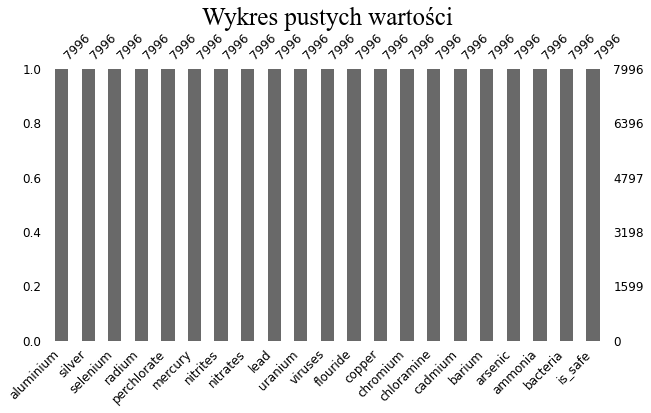

In [10]:
mgno.bar(df, figsize=(10,5), fontsize=12,sort="ascending");
plt.title('Wykres pustych wartości',fontdict=fontdict)
plt.show()

We can see that the data is of good quality because it does not have any missing data

### Descriptive statistics

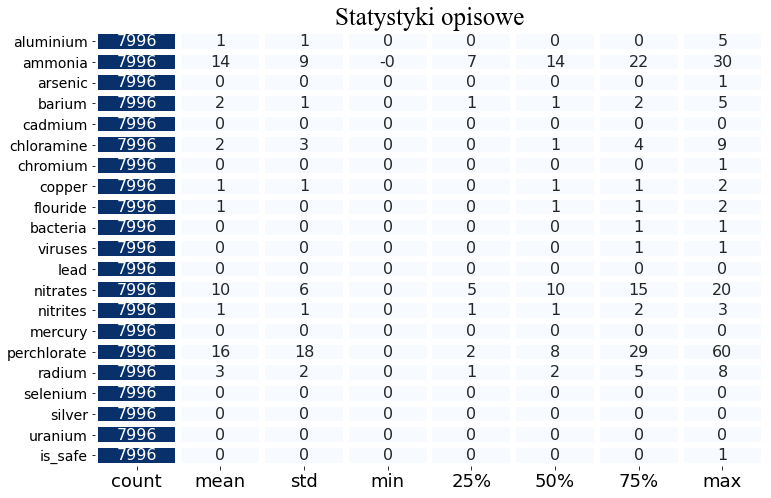

In [11]:
desc = df.describe().T
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(desc,annot=True,cmap = "Blues", fmt= '.0f',
            ax=ax,linewidths = 5, cbar = False,
            annot_kws={"size": 16})
plt.xticks(size = 18)
plt.yticks(size = 14, rotation = 0)
plt.title("Statystyki opisowe", fontdict=fontdict)
plt.show()

There is one feature, where mean is slightly higher than median ('perchlorate'). It may be indicate of skewness of the distribution. <br>
Based on those numbers I would say, that distribution looks quite fine, but I will make sure by checking it using plots.

### Test for normality of distribtion

Base on the function description: "This function tests the null hypothesis that a sample comes from a normal distribution.". So: <br>
- H0 = Sample comes from a normal distribution <br>
- H1 = Sample not come from a normal distribution

In [12]:
cols = df.columns[:-1]
for col in cols:
    alpha = 0.05
    p_value = scipy.stats.normaltest(df[col])[1]
    if(p_value < alpha):
        print('For feature \'' + col +'\' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.')
    else:
        print('For feature \'' + col +'\' null hypothesis can not be rejected. Sample COMES from normal distribution.')

For feature 'aluminium' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'ammonia' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'arsenic' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'barium' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'cadmium' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'chloramine' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'chromium' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'copper' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'flouride' null hypothesis can be rejected. Sample DOES NOT come from normal distribution.
For feature 'bacteria' null hypothesis can be rejected. Sample DOES NOT come 

Thanks to statistical tests we can see that all variables do not have normal distribution

### Testing the Skewness of the Data 

In [13]:
cols = df.columns[:-1]
for col in cols:
    print("{} = {}".format(col,df[col].skew()))

aluminium = 2.0134627045986115
ammonia = 0.026804485284098088
arsenic = 1.9852414162523806
barium = 0.6609568467500901
cadmium = 0.4782263714938959
chloramine = 0.888122552573934
chromium = 1.0281875935048819
copper = 0.25355804997424575
flouride = -0.039733321559774694
bacteria = 0.5544174786607943
viruses = 0.4245668331619121
lead = -0.060600898324101045
nitrates = -0.04205984794520487
nitrites = -0.49821155027632374
mercury = -0.08172613642495993
perchlorate = 0.9377671483069505
radium = 0.548390578720597
selenium = 0.010494764277532776
silver = 1.0294889184168248
uranium = -0.02703998376636728


We have both positive skew variables and negative skew variables.The most strongly skewed variables are  ("aluminum", "arsenic", "chromium", "silver") <br> 
What a large number of outliers can mean

### Removing the skewness

In [14]:
cols = df.columns[:-1]
threshold = 0.2

for col in cols:
    if df[col].skew() > threshold:
        df[col] = np.log1p(df[col])
    else:
        pass

To get rid of the skewness the natural logarithmic value of x+1, where x belongs to all the input array elements.

### Check distribution of numeric features

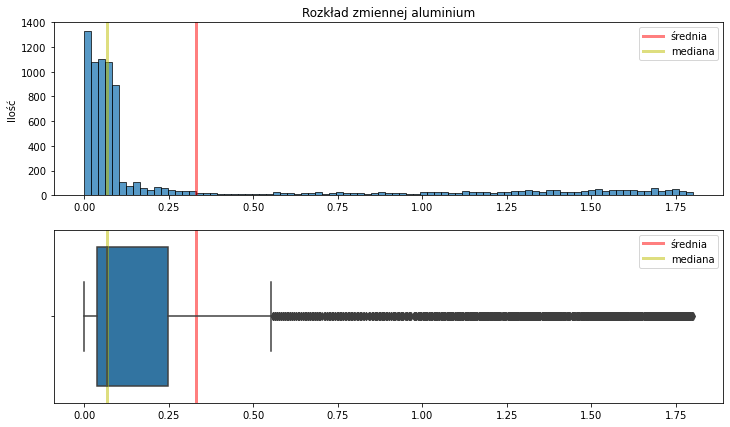

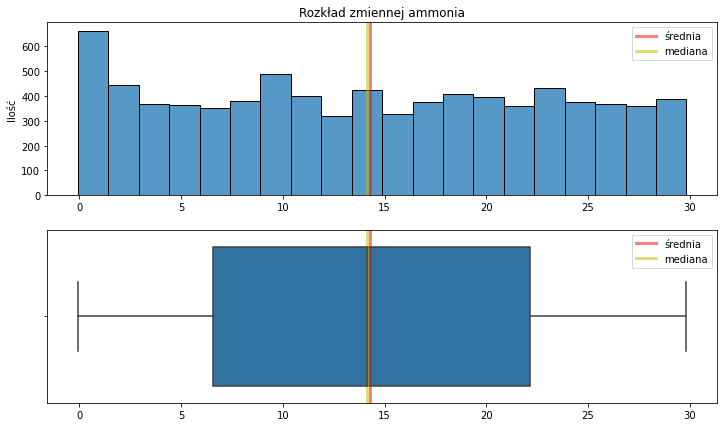

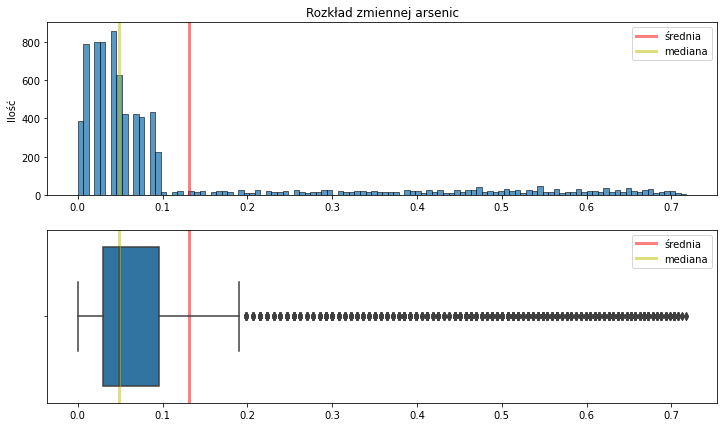

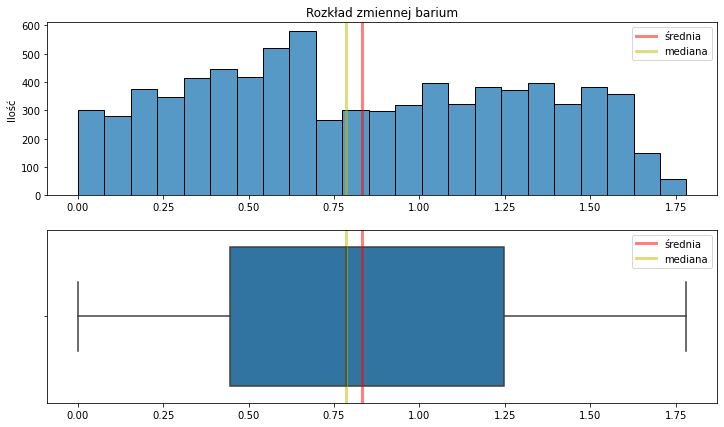

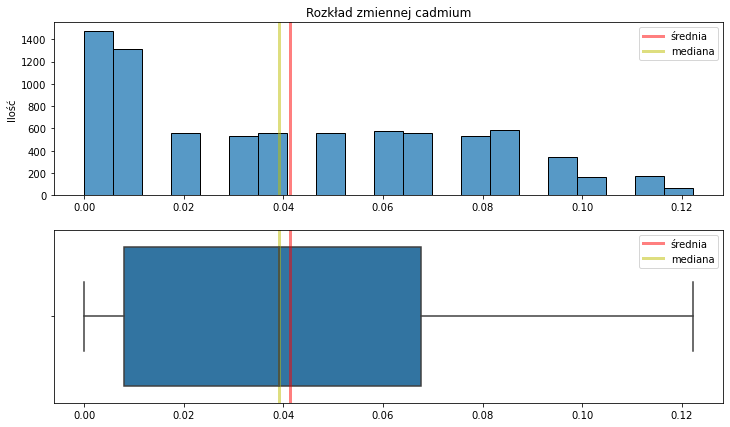

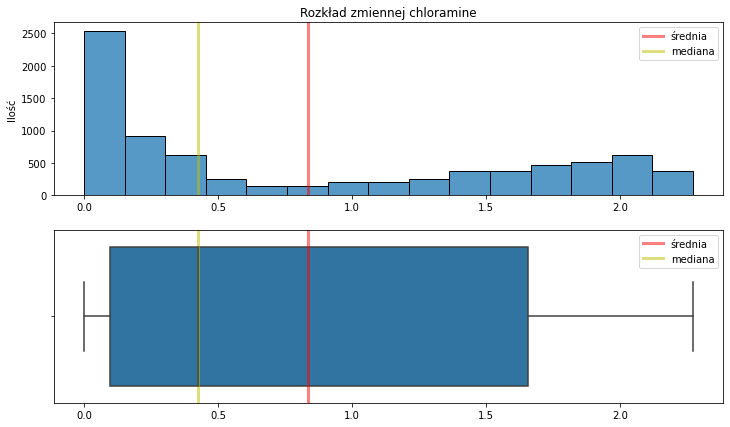

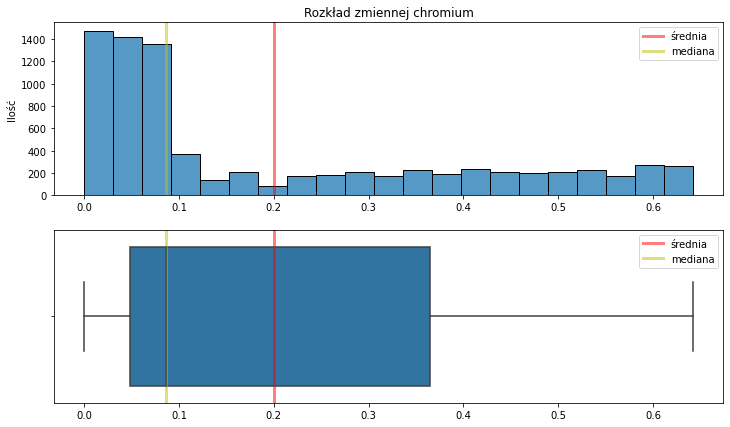

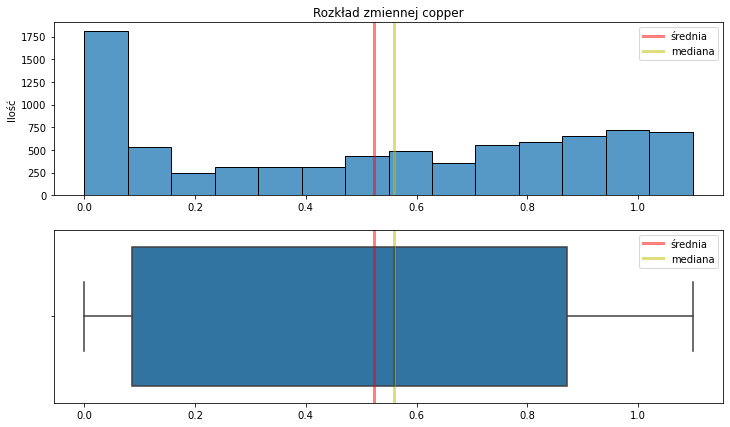

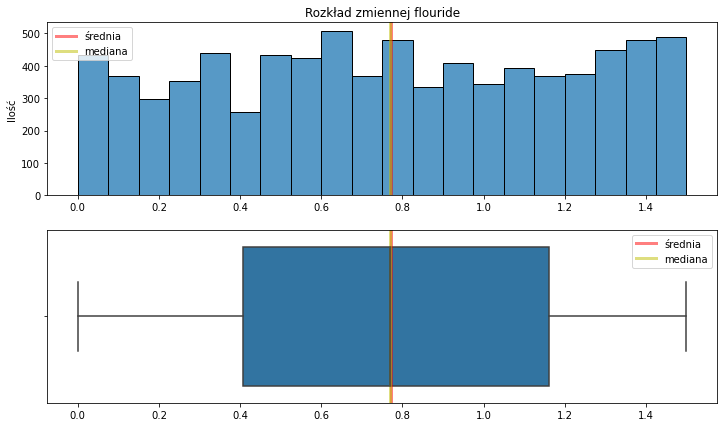

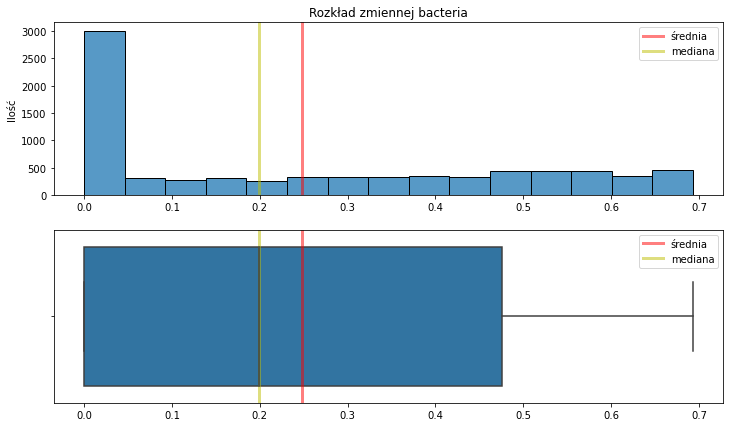

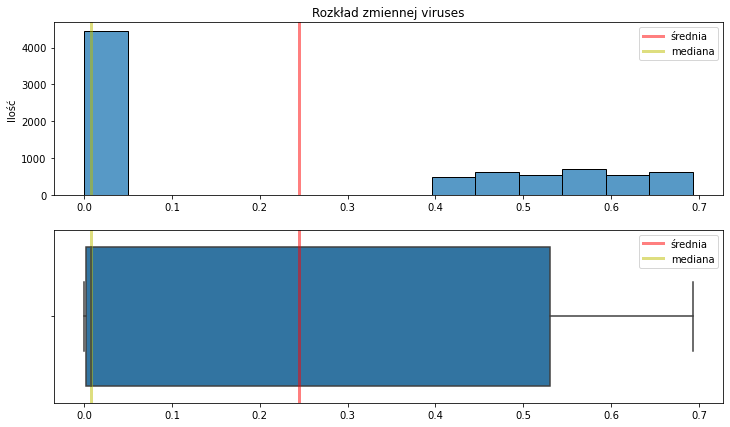

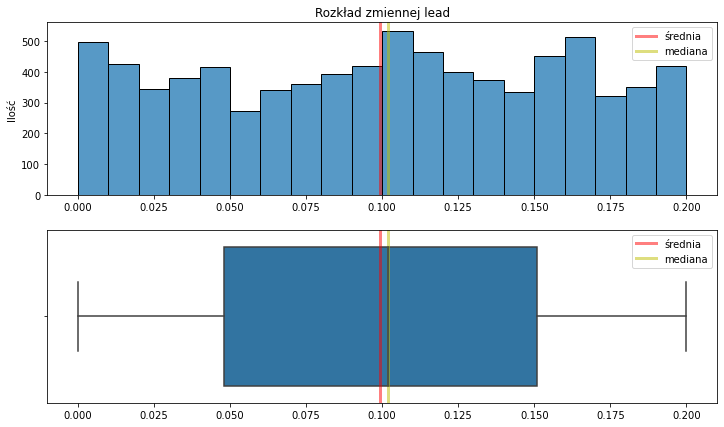

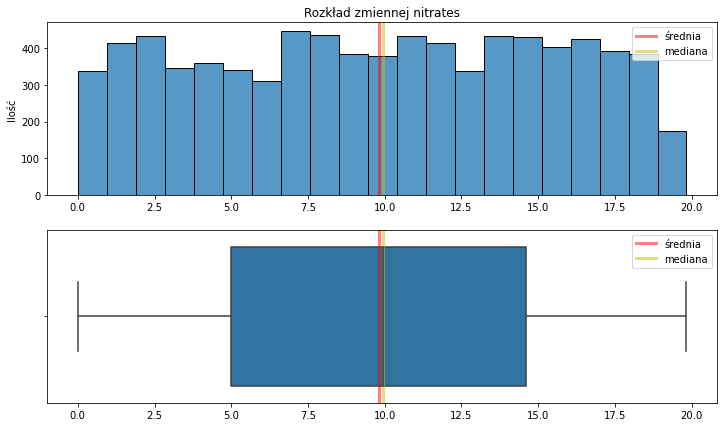

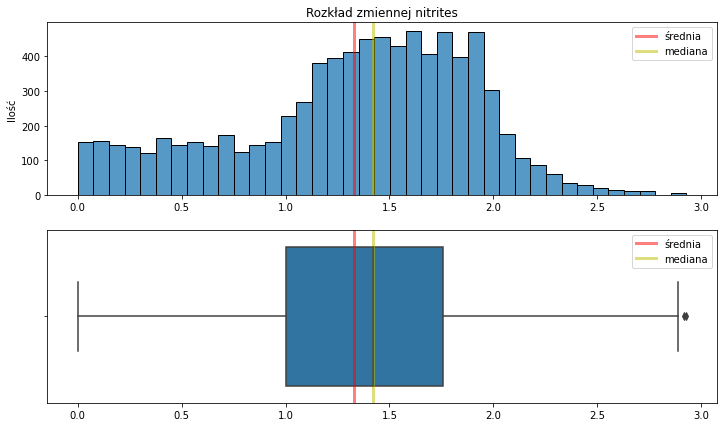

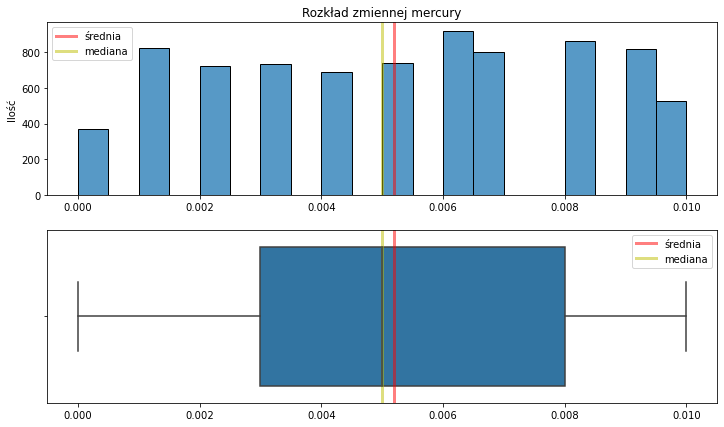

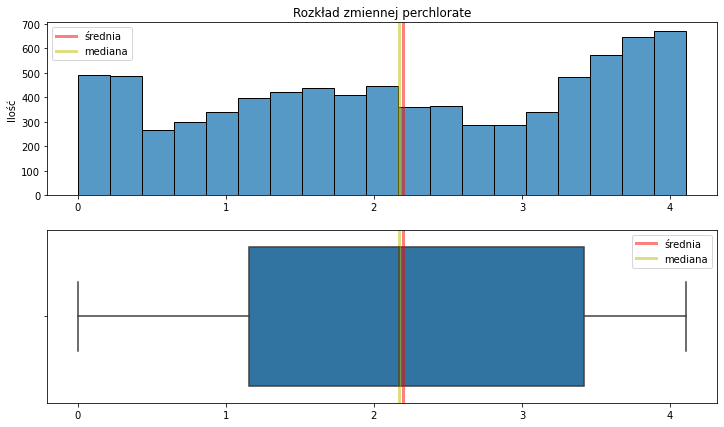

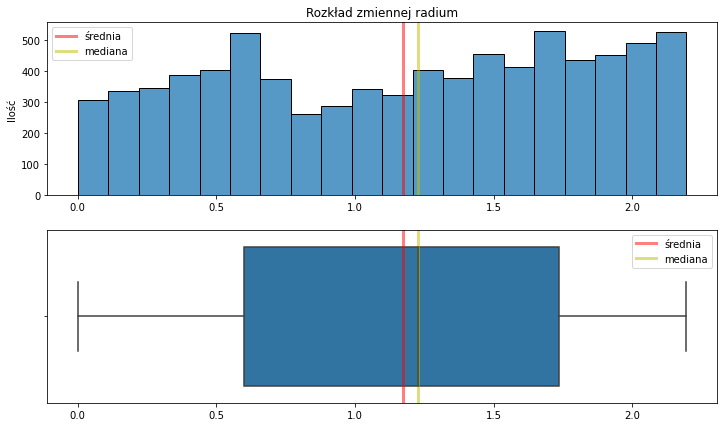

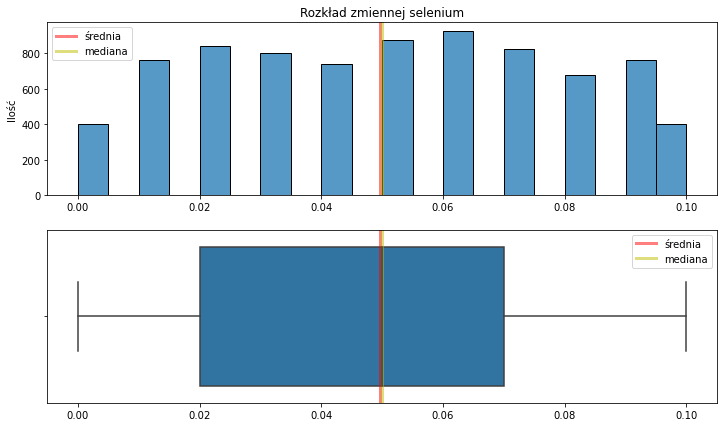

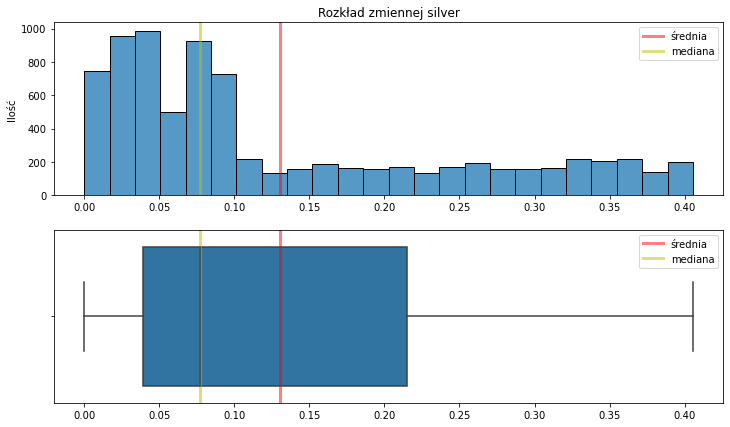

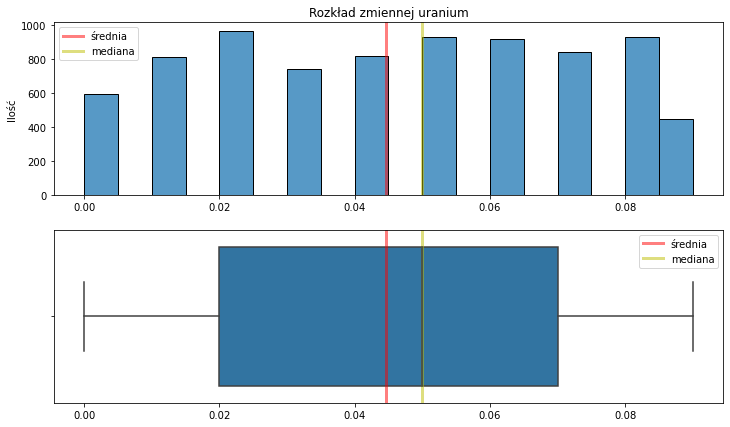

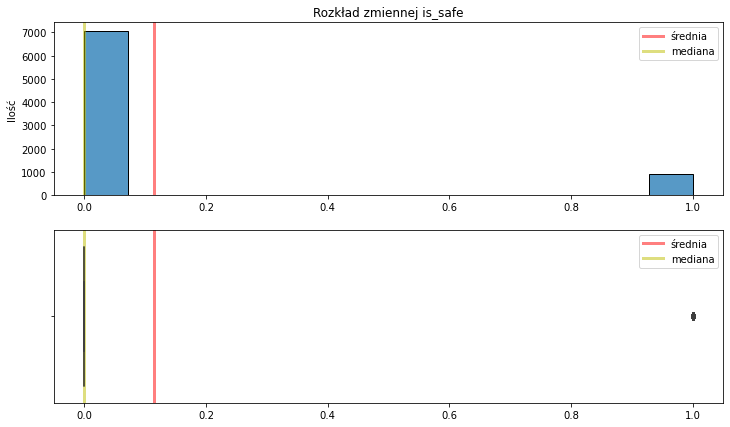

In [15]:
cols = df.columns
for col in cols:
    fig, axes = plt.subplots(2, 1,figsize=(12, 7))
    
    axes[0].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[0].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.histplot(df[col],ax=axes[0])
    
    axes[1].axvline(x=df[col].mean(), linewidth=3, color='r', label="mean", alpha=0.5,)
    axes[1].axvline(x=df[col].median(), linewidth=3, color='y', label="median", alpha=0.5,)
    sns.boxplot(x=df[col],ax=axes[1])

    axes[0].set_ylabel('Ilość')
    axes[0].set_xlabel('')
    axes[0].set_title("Rozkład zmiennej {}".format(col))
    axes[0].legend(["średnia", "mediana"])
    axes[1].legend(["średnia", "mediana"])
    axes[1].set_xlabel('')

After the logarithmic transformation, the distribution of the variables is more like a normal distribution, but we can see that there are outliers in the box plots of all the variables. <br>
The dataset is of medium size, which means that we should avoid removing outlier records and we should consider using non-parametric statistics and algorithms that are not sensitive to outliers  such as tree methods.

### Analysis correlation between variables

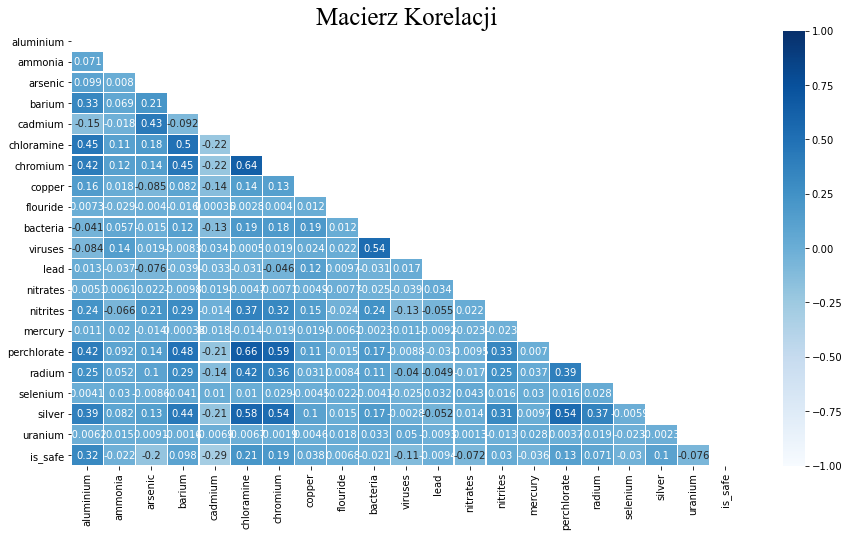

In [16]:
plt.figure(figsize=(15,8))
corr = df.corr(method="spearman")
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True,linewidths=0.2,vmin=-1,vmax=1,mask=mask, cmap='Blues',center=0,cbar_kws={'alpha':0.1})
plt.title('Macierz Korelacji',fontdict=fontdict)
plt.show()

In correlation matrix we used Spearman rank correlation, because there is no assumption about variables distribution, target variable is categorical variable (yes / no), but also dichotomous, <br>
so in ranking it doesn't really matter if it is categorical (as long as we want to detect level of correlation and dependencies, not direction of correlation), it is value based ranking, <br>
so this method is robust to outliers. In the visualization we can see that no variable is highly correlated (close to the 1.00 value) with each other. So all variables are neutrally correlated.

### Target variable

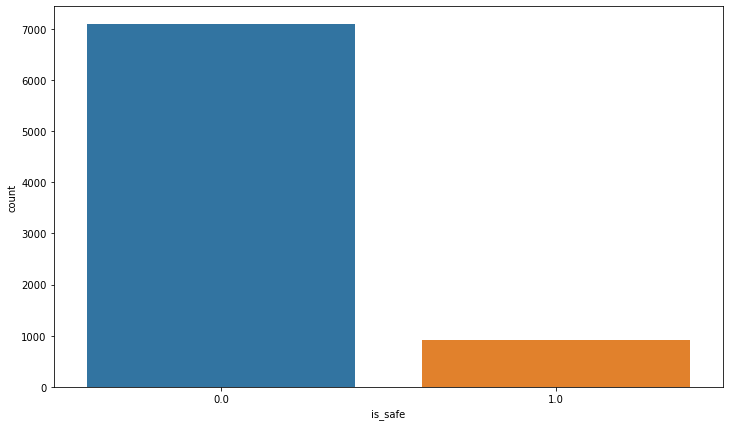

In [17]:
fig = plt.subplots(figsize=(12, 7))
ax.set_title("Ilość próbki is_safe")
sns.countplot(x ='is_safe', data = df);

Not very ballanced data set. Contains around 90 percent of is not safe, and only around 10 percent is safe.

### Preparing data

In [18]:
X  = df.iloc[:,:-1]
y = df.iloc[:,-1]

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state,shuffle=True,stratify=y)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(5597, 20) (5597,)
(2399, 20) (2399,)


### Feature selection

Feature Importances :  [0.11843753 0.04728805 0.05091065 0.0147578  0.24809077 0.0315235
 0.01101132 0.01814788 0.01057607 0.04792321 0.03903284 0.02472383
 0.03871579 0.02514082 0.01441763 0.07986762 0.03710439 0.0305174
 0.06549133 0.04632153]


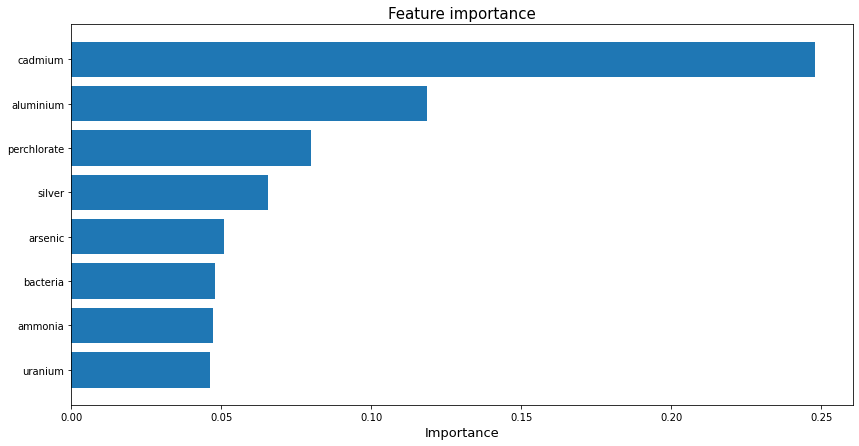

In [20]:
xgb_model = xgb.XGBClassifier(random_state = random_state,eval_metric = "mlogloss")
xgb_model.fit(X_train, y_train)
plt.rcParams["figure.figsize"] = (14, 7)
print("Feature Importances : ", xgb_model.feature_importances_)
drop_col_index = []
display_col_name = []
display_col_value = []
for i,feature in enumerate(xgb_model.feature_importances_):
    if feature < 0.04:
        drop_col_index.append(i)
    else:
        display_col_name.append(i)
        display_col_value.append(feature)


X_train=X_train.drop(df.columns[drop_col_index], axis=1)
X_test=X_test.drop(df.columns[drop_col_index], axis=1)

list_name = []
for num,col in enumerate(df.columns[:-1]):
    if num in display_col_name:
        list_name.append(col)
sorted_list=list(zip(list_name, display_col_value))
sorted_list.sort(key=lambda y: y[1])

features_sorted = []
importance_sorted = []

for i in sorted_list:
    features_sorted += [i[1]]
    importance_sorted += [i[0]]

plt.title("Feature importance", fontsize=15)
plt.xlabel("Importance", fontsize=13)
importance_sorted
plt.barh(importance_sorted, features_sorted);

I choose only the columns that are more important than the threshold which is 0.04, this way we reduce the option to overfitting the model because <br>
it will not be as complex (less features) and less computing power is needed to train the models The columns I am throwing out are <br> 
('barium', 'chloramine', 'chromium', 'copper', 'flouride', 'viruses', 'lead', 'nitrites', 'nitrites','mercury', 'radium', 'selenium')

### Oversampling 

(9918, 8) (9918,)


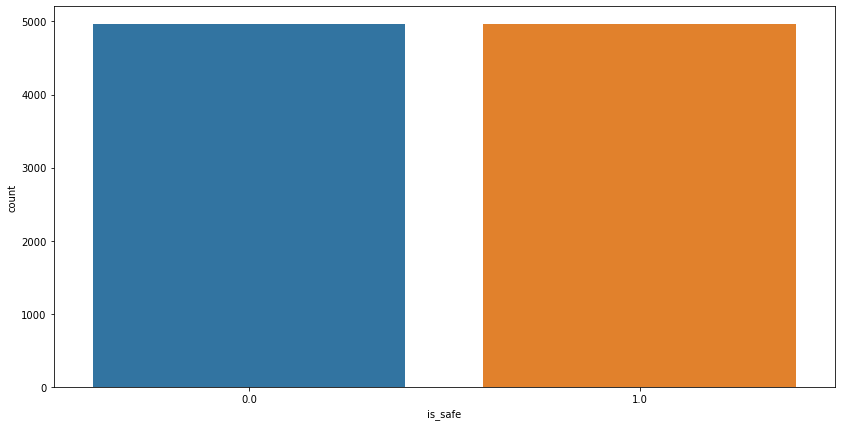

In [21]:
smote = SMOTE(random_state=random_state)
X_train, y_train = smote.fit_resample(X_train, y_train)
print(X_train.shape,y_train.shape)
full = X_train.copy()
full["is_safe"] = y_train
sns.countplot(x ='is_safe', data = full);

We do oversampling for our target feature to better balance the dataset. That is, so that the model can better learn how to distinguish values from each other

### Creating a pipeline 

In [47]:
X_train

,aluminium,ammonia,arsenic,cadmium,bacteria,perchlorate,silver,uranium
0,0.086178,18.670000,0.086178,0.048790,0.000000,0.936093,0.039221,0.080000
1,0.058269,14.020000,0.009950,0.076961,0.000000,1.978239,0.048790,0.000000
2,0.076961,0.220000,0.076961,0.039221,0.270027,0.770108,0.019803,0.070000
3,0.246860,20.840000,0.512824,0.009950,0.438255,2.517696,0.148420,0.040000
4,0.009950,20.660000,0.058269,0.019803,0.000000,0.703098,0.048790,0.000000
...,...,...,...,...,...,...,...,...
9913,1.552921,2.489303,0.038396,0.001998,0.003940,2.789628,0.128458,0.029154
9914,0.753779,1.818318,0.014749,0.006002,0.000000,2.503258,0.211984,0.017553
9915,1.359574,9.204222,0.046511,0.005392,0.404827,3.476962,0.177424,0.070519
9916,1.102030,6.304159,0.398257,0.030986,0.349733,3.771129,0.156385,0.018318


In [22]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

In [23]:
pipeline = Pipeline([
    #('transformation', PowerTransformer()),
    #('smote', SMOTE(random_state=random_state)),
    #('feature_selection', SelectFromModel(xgb.XGBClassifier(random_state = random_state,eval_metric = "mlogloss",use_label_encoder=False),threshold=0.03)),
    ('numerical_imputer', KNNImputer(missing_values=np.nan, n_neighbors=3)),
    ('numerical_transformer', StandardScaler())
])

In [24]:
data_processing_pipeline = ColumnTransformer([
    ("numerical_preprocessor", pipeline, numerical_columns)
])

print(data_processing_pipeline.fit_transform(X_train, y_train).shape)
data_processing_pipeline.fit_transform(X_train, y_train)

(9918, 8)


array([[-7.79586587e-01,  5.26202297e-01, -7.10855893e-02, ...,
        -1.29013700e+00, -9.20549162e-01,  1.50254037e+00],
       [-8.24604769e-01, -1.38874409e-03, -5.70031461e-01, ...,
        -3.93994094e-01, -8.36504738e-01, -1.65729957e+00],
       [-7.94453483e-01, -1.56714280e+00, -1.31413163e-01, ...,
        -1.43286792e+00, -1.09108996e+00,  1.10756038e+00],
       ...,
       [ 1.27446112e+00, -5.47789063e-01, -3.30723932e-01, ...,
         8.94760126e-01,  2.93229337e-01,  1.12805453e+00],
       [ 8.59030164e-01, -8.76831435e-01,  1.97162586e+00, ...,
         1.14771495e+00,  1.08452841e-01, -9.33764431e-01],
       [ 1.34346455e+00,  2.92724160e-01, -4.59543532e-01, ...,
         7.98709730e-01,  1.06625830e-01, -1.24250500e-01]])

In [25]:
set_config(display='diagram')
display(data_processing_pipeline)
set_config(display='text')

ColumnTransformer(transformers=[('numerical_preprocessor',
                                 Pipeline(steps=[('numerical_imputer',
                                                  KNNImputer(n_neighbors=3)),
                                                 ('numerical_transformer',
                                                  StandardScaler())]),
                                 Index(['aluminium', 'ammonia', 'arsenic', 'cadmium', 'bacteria', 'perchlorate',
       'silver', 'uranium'],
      dtype='object'))])

### Creating a parameter grid 

In [27]:
classifiers = [
     {
        'name': 'BaggingClassifier()',
        'class': BaggingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'random_state' : 42
           }
    },
    {
        'name': 'RandomForestClassifier()',
        'class': RandomForestClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'min_samples_leaf':hp.uniformint('min_samples_leaf', 1, 5),
            'min_samples_split':hp.uniformint('min_samples_split', 2, 10),
            'bootstrap': hp.choice('bootstrap', [True,  False]),
            'max_features': hp.choice('max_features', ['auto', 'sqrt']),
            'random_state' : 42
           }
    },
     {
        'name': 'GradientBoostingClassifier()',
        'class': GradientBoostingClassifier(),
        'max_evals': 100,
        'params': {
            'n_estimators': hp.uniformint('n_estimators', 100, 500),
            'max_depth': hp.uniformint('max_depth', 2, 20),
            'random_state' : 42
           }
    },
    {
        'name': 'XGBClassifier()',
        'class': xgb.XGBClassifier(eval_metric = "mlogloss"),
        'max_evals': 100,
        'eval_metric': "mlogloss",
        'params' : {
            'learning_rate': hp.loguniform ('learning_rate', 0.01, 0.5),
            'max_depth': hp.choice('max_depth', np.arange(2, 11).tolist()),
            'min_child_weight': hp.choice('min_child_weight', np.arange(0, 101).tolist()),
            'gamma': hp.loguniform('gamma', 0.0, 2.0),
            'subsample': hp.uniform('subsample', 0.5, 1.0),
            'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
            'colsample_bylevel': hp.uniform('colsample_bylevel', 0.5, 1.0),
            'reg_alpha': hp.loguniform('reg_alpha', 0.0, 2.0),
            'reg_lambda': hp.loguniform('reg_lambda', 0.0, 2.0),
            'random_state' : 42
        }
    },
]

In [28]:
# Create a storage location for result logs
logger = log(path="./logs/", file="score.logs")

### Model training and selecting the best parameters on a cross validation set

In [30]:
def objective(space):
    pipe_params = {}
    
    for s in space:
        pipe_params[f"classifier__{s}"] = space[s]
        
    pipe.set_params(**pipe_params)
    

    score = cross_val_score(pipe, X_train, y_train, cv=10, scoring='accuracy',n_jobs=-1,error_score="raise").mean()
    return {'loss': 1- score, 'status': STATUS_OK, 'accuracy': score}

In [31]:
trials_df = []
 
for cl in classifiers:
    cl_name = cl['class'].__class__.__name__
    print(f"\n\n{cl_name}")
    
    pipe = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', cl['class'])
    ])
    
    space = {}
    for k in cl['params']:
        space[k] = cl['params'][k]
    
    max_evals = cl['max_evals']
    
    trials = Trials()
    best = fmin(fn=objective,
                    space=space,
                    algo=tpe.suggest,
                    max_evals=max_evals,
                    trials=trials)
     
    best_params = space_eval(space, best)
    print('\nThe best params:')
    print ("{:<30} {}".format('Parameter','Selected'))
    for k, v in best_params.items():
        print ("{:<30} {}".format(k, v))
    
    for trial in trials.trials:
        trials_df.append({
            'classifier': cl_name,
            'loss': trial['result']['loss'],
            'accuracy': trial['result']['accuracy'],
            'params': trial['misc']['vals']
            })



GradientBoostingClassifier
  0%|                                       | 0/100 [00:00<?, ?trial/s, best loss=?]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 0 trials


  1%|          | 1/100 [01:14<2:03:20, 74.75s/trial, best loss: 0.06110122147716557]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 1/1 trials with best loss 0.061101


  2%|▏         | 2/100 [01:19<1:27:53, 53.81s/trial, best loss: 0.03831092737866615]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 2/2 trials with best loss 0.038311


  3%|▎         | 3/100 [01:30<1:06:04, 40.87s/trial, best loss: 0.03054740649718435]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 3/3 trials with best loss 0.030547


  4%|▍          | 4/100 [01:56<58:26, 36.53s/trial, best loss: 0.029438433807493114]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 4/4 trials with best loss 0.029438


  5%|▌          | 5/100 [02:03<43:36, 27.54s/trial, best loss: 0.029438433807493114]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 5/5 trials with best loss 0.029438


  6%|▋          | 6/100 [02:50<52:21, 33.42s/trial, best loss: 0.029438433807493114]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 6/6 trials with best loss 0.029438


  7%|▊          | 7/100 [03:23<51:26, 33.18s/trial, best loss: 0.029438433807493114]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 7/7 trials with best loss 0.029438


  8%|▋        | 8/100 [04:53<1:17:20, 50.44s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 8/8 trials with best loss 0.027019


  9%|▊        | 9/100 [05:40<1:14:37, 49.20s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 9/9 trials with best loss 0.027019


 10%|▊       | 10/100 [06:09<1:04:58, 43.31s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000959 seconds
INFO TPE using 10/10 trials with best loss 0.027019


 11%|█         | 11/100 [06:27<52:53, 35.66s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.001033 seconds
INFO TPE using 11/11 trials with best loss 0.027019


 12%|▉       | 12/100 [08:13<1:23:11, 56.72s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000964 seconds
INFO TPE using 12/12 trials with best loss 0.027019


 13%|█       | 13/100 [10:14<1:50:22, 76.12s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 13/13 trials with best loss 0.027019


 14%|█       | 14/100 [11:01<1:36:33, 67.37s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.001031 seconds
INFO TPE using 14/14 trials with best loss 0.027019


 15%|█▏      | 15/100 [11:25<1:16:45, 54.18s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000993 seconds
INFO TPE using 15/15 trials with best loss 0.027019


 16%|█▎      | 16/100 [14:05<2:00:26, 86.02s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000966 seconds
INFO TPE using 16/16 trials with best loss 0.027019


 17%|█▎      | 17/100 [14:16<1:27:53, 63.53s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 17/17 trials with best loss 0.027019


 18%|█▍      | 18/100 [15:02<1:19:32, 58.20s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 18/18 trials with best loss 0.027019


 19%|█▌      | 19/100 [15:36<1:08:54, 51.05s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.015614 seconds
INFO TPE using 19/19 trials with best loss 0.027019


 20%|█▌      | 20/100 [17:36<1:35:26, 71.58s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000994 seconds
INFO TPE using 20/20 trials with best loss 0.027019


 21%|█▋      | 21/100 [18:42<1:32:06, 69.95s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.001039 seconds
INFO TPE using 21/21 trials with best loss 0.027019


 22%|█▊      | 22/100 [19:32<1:23:17, 64.08s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 22/22 trials with best loss 0.027019


 23%|█▊      | 23/100 [20:27<1:18:50, 61.43s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 23/23 trials with best loss 0.027019


 24%|██▍       | 24/100 [20:36<57:51, 45.68s/trial, best loss: 0.027018773802936047]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 24/24 trials with best loss 0.027019


 25%|██      | 25/100 [22:00<1:11:18, 57.04s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 25/25 trials with best loss 0.026918


 26%|██      | 26/100 [23:51<1:30:21, 73.27s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 26/26 trials with best loss 0.026918


 27%|██▏     | 27/100 [24:53<1:24:57, 69.83s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 27/27 trials with best loss 0.026918


 28%|██▏     | 28/100 [26:35<1:35:16, 79.40s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 28/28 trials with best loss 0.026918


 29%|██▎     | 29/100 [27:48<1:31:47, 77.58s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.001007 seconds
INFO TPE using 29/29 trials with best loss 0.026918


 30%|██▍     | 30/100 [29:36<1:41:10, 86.72s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000945 seconds
INFO TPE using 30/30 trials with best loss 0.026918


 31%|██▏    | 31/100 [32:08<2:02:17, 106.35s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000967 seconds
INFO TPE using 31/31 trials with best loss 0.026918


 32%|██▌     | 32/100 [32:39<1:35:01, 83.85s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 32/32 trials with best loss 0.026918


 33%|██▋     | 33/100 [33:39<1:25:26, 76.52s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 33/33 trials with best loss 0.026918


 34%|██▋     | 34/100 [34:40<1:19:01, 71.84s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 34/34 trials with best loss 0.026918


 35%|██▊     | 35/100 [36:09<1:23:37, 77.19s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 35/35 trials with best loss 0.026918


 36%|██▉     | 36/100 [37:20<1:20:14, 75.23s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 36/36 trials with best loss 0.026918


 37%|██▉     | 37/100 [38:40<1:20:35, 76.75s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 37/37 trials with best loss 0.026918


 38%|███▊      | 38/100 [38:53<59:27, 57.54s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 38/38 trials with best loss 0.026918


 39%|███▉      | 39/100 [39:24<50:31, 49.70s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 39/39 trials with best loss 0.026918


 40%|███▏    | 40/100 [41:20<1:09:30, 69.52s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 40/40 trials with best loss 0.026918


 41%|████      | 41/100 [41:53<57:35, 58.56s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 41/41 trials with best loss 0.026918


 42%|████▏     | 42/100 [42:12<45:01, 46.58s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.001001 seconds
INFO TPE using 42/42 trials with best loss 0.026918


 43%|███▍    | 43/100 [43:55<1:00:23, 63.58s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 43/43 trials with best loss 0.026918


 44%|███▌    | 44/100 [45:22<1:05:59, 70.70s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000964 seconds
INFO TPE using 44/44 trials with best loss 0.026918


 45%|███▌    | 45/100 [46:58<1:11:43, 78.24s/trial, best loss: 0.026917967351323235]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 45/45 trials with best loss 0.026918


 46%|████▌     | 46/100 [47:37<59:44, 66.39s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000964 seconds
INFO TPE using 46/46 trials with best loss 0.026817


 47%|████▋     | 47/100 [47:52<45:07, 51.09s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 47/47 trials with best loss 0.026817


 48%|████▊     | 48/100 [48:38<42:51, 49.45s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.001109 seconds
INFO TPE using 48/48 trials with best loss 0.026817


 49%|████▉     | 49/100 [49:14<38:36, 45.42s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 49/49 trials with best loss 0.026817


 50%|█████     | 50/100 [49:24<29:04, 34.88s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 50/50 trials with best loss 0.026817


 51%|█████     | 51/100 [49:51<26:28, 32.42s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 51/51 trials with best loss 0.026817


 52%|█████▏    | 52/100 [49:59<20:01, 25.03s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 52/52 trials with best loss 0.026817


 53%|█████▎    | 53/100 [50:13<17:00, 21.71s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.001034 seconds
INFO TPE using 53/53 trials with best loss 0.026817


 54%|█████▍    | 54/100 [50:41<18:03, 23.56s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 54/54 trials with best loss 0.026817


 55%|█████▌    | 55/100 [51:08<18:36, 24.80s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000963 seconds
INFO TPE using 55/55 trials with best loss 0.026817


 56%|█████▌    | 56/100 [51:33<18:10, 24.78s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 56/56 trials with best loss 0.026817


 57%|█████▋    | 57/100 [52:01<18:27, 25.77s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 57/57 trials with best loss 0.026817


 58%|█████▊    | 58/100 [52:17<15:58, 22.83s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 58/58 trials with best loss 0.026817


 59%|█████▉    | 59/100 [52:47<17:06, 25.04s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000996 seconds
INFO TPE using 59/59 trials with best loss 0.026817


 60%|██████    | 60/100 [53:35<21:12, 31.80s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 60/60 trials with best loss 0.026817


 61%|██████    | 61/100 [54:00<19:16, 29.65s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 61/61 trials with best loss 0.026817


 62%|██████▏   | 62/100 [54:45<21:45, 34.35s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 62/62 trials with best loss 0.026817


 63%|██████▎   | 63/100 [55:34<23:58, 38.87s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 63/63 trials with best loss 0.026817


 64%|██████▍   | 64/100 [57:04<32:28, 54.13s/trial, best loss: 0.026816652289964438]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 64/64 trials with best loss 0.026817


 65%|██████▌   | 65/100 [57:48<29:48, 51.11s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 65/65 trials with best loss 0.026716


 66%|██████▌   | 66/100 [58:33<27:50, 49.14s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 66/66 trials with best loss 0.026716


 67%|██████▋   | 67/100 [58:53<22:21, 40.65s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 67/67 trials with best loss 0.026716


 68%|██████▊   | 68/100 [59:23<19:52, 37.25s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000999 seconds
INFO TPE using 68/68 trials with best loss 0.026716


 69%|█████▌  | 69/100 [1:00:27<23:25, 45.33s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 69/69 trials with best loss 0.026716


 70%|█████▌  | 70/100 [1:01:17<23:23, 46.79s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.001031 seconds
INFO TPE using 70/70 trials with best loss 0.026716


 71%|█████▋  | 71/100 [1:01:46<20:04, 41.52s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 71/71 trials with best loss 0.026716


 72%|█████▊  | 72/100 [1:02:25<18:54, 40.54s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 72/72 trials with best loss 0.026716


 73%|█████▊  | 73/100 [1:03:03<17:54, 39.78s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 73/73 trials with best loss 0.026716


 74%|█████▉  | 74/100 [1:03:34<16:09, 37.31s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.001030 seconds
INFO TPE using 74/74 trials with best loss 0.026716


 75%|██████  | 75/100 [1:03:48<12:36, 30.25s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 75/75 trials with best loss 0.026716


 76%|██████  | 76/100 [1:04:51<16:01, 40.05s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 76/76 trials with best loss 0.026716


 77%|██████▏ | 77/100 [1:05:47<17:15, 45.02s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 77/77 trials with best loss 0.026716


 78%|██████▏ | 78/100 [1:05:56<12:32, 34.20s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 78/78 trials with best loss 0.026716


 79%|██████▎ | 79/100 [1:06:34<12:16, 35.07s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 79/79 trials with best loss 0.026716


 80%|██████▍ | 80/100 [1:07:10<11:50, 35.53s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 80/80 trials with best loss 0.026716


 81%|██████▍ | 81/100 [1:08:30<15:26, 48.79s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000994 seconds
INFO TPE using 81/81 trials with best loss 0.026716


 82%|██████▌ | 82/100 [1:09:17<14:27, 48.21s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 82/82 trials with best loss 0.026716


 83%|██████▋ | 83/100 [1:09:40<11:33, 40.78s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.001015 seconds
INFO TPE using 83/83 trials with best loss 0.026716


 84%|██████▋ | 84/100 [1:09:55<08:47, 32.95s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 84/84 trials with best loss 0.026716


 85%|██████▊ | 85/100 [1:10:31<08:30, 34.04s/trial, best loss: 0.026715845838351626]

INFO build_posterior_wrapper took 0.000995 seconds
INFO TPE using 85/85 trials with best loss 0.026716


 86%|███████▋ | 86/100 [1:11:09<08:13, 35.22s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 86/86 trials with best loss 0.026716


 87%|███████▊ | 87/100 [1:12:07<09:06, 42.05s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 87/87 trials with best loss 0.026716


 88%|███████▉ | 88/100 [1:13:03<09:12, 46.01s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000993 seconds
INFO TPE using 88/88 trials with best loss 0.026716


 89%|████████ | 89/100 [1:13:24<07:03, 38.51s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 89/89 trials with best loss 0.026716


 90%|████████ | 90/100 [1:13:57<06:10, 37.08s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 90/90 trials with best loss 0.026716


 91%|████████▏| 91/100 [1:14:07<04:18, 28.73s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 91/91 trials with best loss 0.026716


 92%|████████▎| 92/100 [1:14:21<03:14, 24.29s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000998 seconds
INFO TPE using 92/92 trials with best loss 0.026716


 93%|████████▎| 93/100 [1:16:24<06:18, 54.13s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000997 seconds
INFO TPE using 93/93 trials with best loss 0.026716


 94%|████████▍| 94/100 [1:17:02<04:54, 49.06s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.001029 seconds
INFO TPE using 94/94 trials with best loss 0.026716


 95%|████████▌| 95/100 [1:17:22<03:22, 40.42s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.001000 seconds
INFO TPE using 95/95 trials with best loss 0.026716


 96%|████████▋| 96/100 [1:19:50<04:51, 72.88s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 96/96 trials with best loss 0.026716


 97%|████████▋| 97/100 [1:20:21<03:00, 60.13s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000994 seconds
INFO TPE using 97/97 trials with best loss 0.026716


 98%|████████▊| 98/100 [1:21:02<01:48, 54.31s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.001032 seconds
INFO TPE using 98/98 trials with best loss 0.026716


 99%|████████▉| 99/100 [1:22:10<00:58, 58.63s/trial, best loss: 0.02671574411640254]

INFO build_posterior_wrapper took 0.000000 seconds
INFO TPE using 99/99 trials with best loss 0.026716


100%|████████| 100/100 [1:24:06<00:00, 50.47s/trial, best loss: 0.02671574411640254]

The best params:
Parameter                      Selected
max_depth                      7
n_estimators                   414
random_state                   42


### Table with the best classifiers and their parameters

In [32]:
trials_df = pd.DataFrame(trials_df)
trials_df.sort_values('accuracy', ascending=False)

,classifier,loss,accuracy,params
93,GradientBoostingClassifier,0.026716,0.973284,"{'max_depth': [7.0], 'n_estimators': [414.0]}"
85,GradientBoostingClassifier,0.026716,0.973284,"{'max_depth': [7.0], 'n_estimators': [414.0]}"
64,GradientBoostingClassifier,0.026716,0.973284,"{'max_depth': [7.0], 'n_estimators': [433.0]}"
71,GradientBoostingClassifier,0.026716,0.973284,"{'max_depth': [7.0], 'n_estimators': [433.0]}"
45,GradientBoostingClassifier,0.026817,0.973183,"{'max_depth': [7.0], 'n_estimators': [438.0]}"
...,...,...,...,...
0,GradientBoostingClassifier,0.061101,0.938899,"{'max_depth': [18.0], 'n_estimators': [382.0]}"
9,GradientBoostingClassifier,0.061303,0.938697,"{'max_depth': [18.0], 'n_estimators': [138.0]}"
36,GradientBoostingClassifier,0.061303,0.938697,"{'max_depth': [16.0], 'n_estimators': [330.0]}"
17,GradientBoostingClassifier,0.061605,0.938395,"{'max_depth': [18.0], 'n_estimators': [202.0]}"


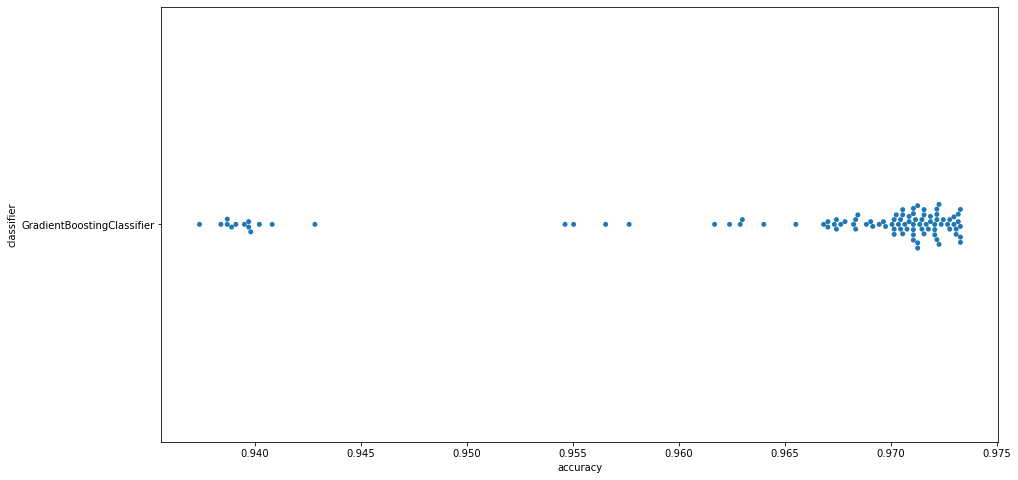

In [34]:
plt.figure(figsize=(15,8))
sns.swarmplot(data=trials_df, y='classifier', x='accuracy');

In [35]:
print("The best model " + top_models.iloc[0][0])
parameters=top_models.iloc[0][3]

keys = []
values = []
for key, value in parameters.items():
    keys.append(key)
    values.append(int(value[0]))
params = dict(zip(keys, values))

The best model GradientBoostingClassifier


### Training the best model on a test set

In [36]:
pipe_finall = Pipeline(steps = [
    ('data_processing_pipeline', data_processing_pipeline),
    ('classifier', GradientBoostingClassifier(**params))
    ])


pipe_finall.fit(X_train, y_train)
filename = 'finalized_model.sav'
pickle.dump(pipe_finall, open(filename, 'wb'))

In [76]:
data_processing_pipeline.transform(X_test)
y_pred = pipe_finall.predict(X_test)
y_pred_proba = pipe_finall.predict_proba(X_test)
y_pred_proba = y_pred_proba[:,1]

### Quality assessment of the classifier

In [77]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.98      0.97      2125
         1.0       0.80      0.75      0.77       274

    accuracy                           0.95      2399
   macro avg       0.88      0.86      0.87      2399
weighted avg       0.95      0.95      0.95      2399



We can see that the model did a much better job of classifying 0 values than 1, because there were far more of them and we didn't have to add them to the dataset 

In [85]:
print("Accuracy = ",accuracy_score(y_test,y_pred))
print("Recall = ",recall_score(y_test, y_pred))
print("Precision = ",precision_score(y_test, y_pred))
print("F1 = ",f1_score(y_test, y_pred))

Accuracy =  0.9499791579824927
Recall =  0.7481751824817519
Precision =  0.80078125
F1 =  0.7735849056603774


AxesSubplot(0.125,0.125;0.62x0.755)


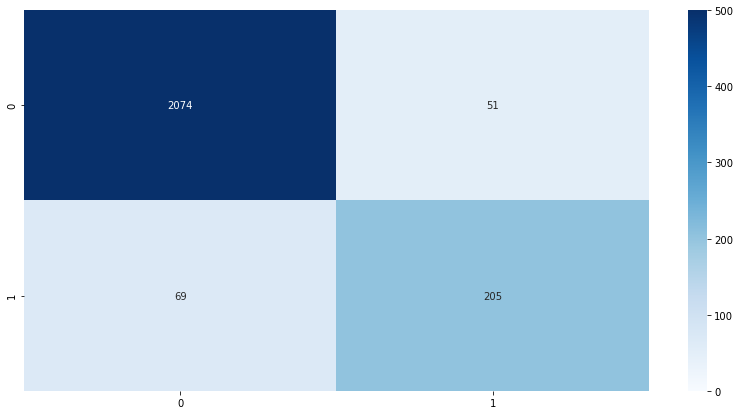

In [79]:
print(sns.heatmap(confusion_matrix(y_test,y_pred),vmin=0,vmax=500,annot=True,cmap='Blues',fmt='g'));

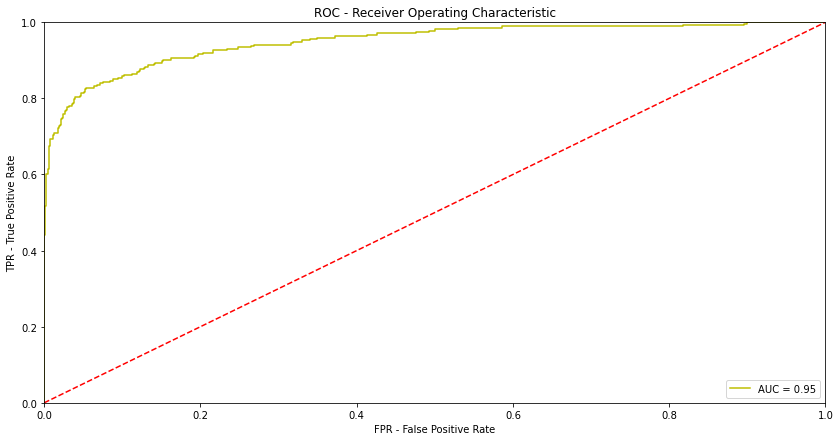

In [89]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.title('ROC - Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'y', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('TPR - True Positive Rate')
plt.xlabel('FPR - False Positive Rate')
plt.show()